In [1]:
from neural_bandits.modules.neural_linear_bandit_module import NeuralLinearBanditModule
from neural_bandits.datasets.statlog import StatlogDataset

import lightning as pl
import torch
from torch.utils.data import DataLoader, Subset

In [2]:
class Encoder(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Encoder, self).__init__()
        self.fc1 = torch.nn.Linear(input_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = torch.nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [3]:
dataset = StatlogDataset()
print(dataset.context_size)
print(len(dataset))

# constrain to 10000 samples
train_loader = DataLoader(Subset(dataset, range(10000)), batch_size=32, shuffle=True)
model = NeuralLinearBanditModule(
        encoder = Encoder(
            input_dim = dataset.context_size * dataset.num_actions,
            hidden_dim = 64,
            output_dim = 32
        ),
        n_features = dataset.context_size * dataset.num_actions,
        n_embedding_size = 32,
)
logger = pl.pytorch.loggers.CSVLogger("logs", name="neural_linear_bandit", flush_logs_every_n_steps=100)
trainer = pl.Trainer(max_epochs=1, logger=logger, log_every_n_steps=1)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


7
58000


In [4]:
trainer.fit(model, train_loader)


  | Name   | Type               | Params | Mode 
------------------------------------------------------
0 | bandit | NeuralLinearBandit | 10.3 K | train
1 | net    | Sequential         | 10.4 K | train
------------------------------------------------------
10.4 K    Trainable params
0         Non-trainable params
10.4 K    Total params
0.041     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
c:\Users\Philipp\miniconda3\envs\neural_bandits\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 0:   0%|          | 1/313 [00:00<00:43,  7.22it/s]

C:\Users\Philipp\2_uni\wise2425\MAB\neural-bandits\src\neural_bandits\modules\neural_linear_bandit_module.py:265: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return torch.nn.functional.mse_loss(y_pred, y)


Epoch 0: 100%|██████████| 313/313 [00:09<00:00, 33.47it/s, v_num=24, reward=0.188, regret=0.812, nn_loss=0.141]  

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 313/313 [00:09<00:00, 33.45it/s, v_num=24, reward=0.188, regret=0.812, nn_loss=0.141]


In [5]:
# load metrics from the logger and plot
import pandas as pd
import numpy as np

metrics_csv = logger.log_dir + "/metrics.csv"
print(metrics_csv)
metrics = pd.read_csv(metrics_csv)
cumulative_reward = np.cumsum(metrics["reward"][:1000])
cumulative_regret = np.cumsum(metrics["regret"][:1000])

logs\neural_linear_bandit\version_24/metrics.csv


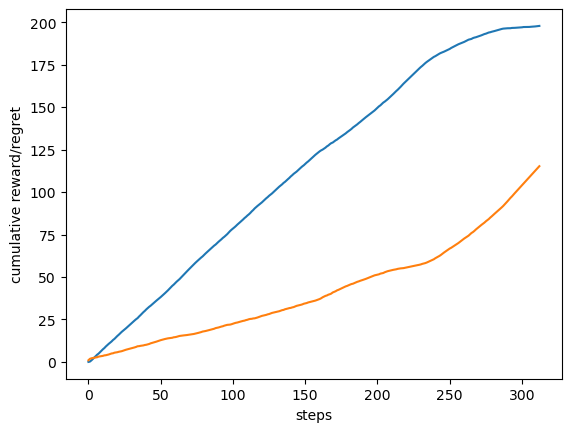

In [6]:
import matplotlib.pyplot as plt
plt.plot(cumulative_reward)
plt.plot(cumulative_regret)
plt.xlabel("steps")
plt.ylabel("cumulative reward/regret")
plt.show()

In [7]:
# average reward
print(sum(metrics["reward"][:100]) / 100)
print(sum(metrics["reward"][:1000]) / 1000)
print(sum(metrics["reward"][:10000]) / 10000)

print(sum(metrics["regret"][:100]) / 100)
print(sum(metrics["regret"][:1000]) / 1000)
print(sum(metrics["regret"][:10000]) / 10000)


0.778125
0.19778125
0.019778125
0.221875
0.11521875
0.011521875


In [8]:
trainer.save_checkpoint("logs/linear_bandit/linear_bandit.ckpt", weights_only=True)

In [9]:
model = NeuralLinearBanditModule.load_from_checkpoint("logs/linear_bandit/linear_bandit.ckpt")

TypeError: NeuralLinearBanditModule.__init__() missing 1 required positional argument: 'encoder'